In [75]:
%reset
%matplotlib inline
%matplotlib inline
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import seaborn as sns
import numba as nb
from numba import jit
from numba import njit
from IPython.display import HTML

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [76]:
# Input parameters:

# Sample Material: AISI Type 316L Stainless Steel

# Plate Initialization:
x_length = .04;          # [m]
y_length = .04;          # [m]
nx = 280;                # number of grid points (Should be at least 1 per mm)
ny = 280;                # number of grid points

# Plate Properties:
T0 = 300; 			        # Initial ambient temperature [K]
q = 80; 			          # laser power [W]
k = 15; 			          # conductivity coefficient [W/m/K]
cp = .5*1000; 			    # specific heat [J/g/c]-->[J/kg/K]
rho = 8*1000; 		      # density [g/cc]-->[kg/m^3]
Melt_Temp = 1670;       # Melting point of material [k]

# Laser Initialization:
#HSP =[.02,.02];       # Initial position of heat source from plate center (x,y) [m]
#vx = -15/1000; 	        # laser speed x [m/s] (from [mm/sec])
#vy = -15/1000; 	        # laser speed y [m/s]
#Print_Path = 'file_Name.txt'  # File that contains print path (x,y) [m]

# Simulation Options:
Max_Time = 3;           # Time simulated [s]
Data_points = 200;      # amount of data sets collected
Frames_Used = 100;       # Frames seen (Should evenly devide Data points)
Scale = 1;              # figure window scale
Window_Pos = [0,0];     # Position of window from plate center (x,y) [m]
Temp_sensitivity = 100;  # pecent of maximum temperature shown on figure
Temp_Definition  = 200; # Levels of temperature displayed on figure

In [77]:
#Create Mesh and inital temp data in 1 dimension
[x,y] = np.meshgrid(np.linspace(-x_length/2,x_length/2,nx),np.linspace(-y_length/2,y_length/2,ny)); # [m]
Time = np.linspace(0,Max_Time,Data_points);
dt = Max_Time/Data_points;
Time_list = list(Time)

Trial_Bound_x = list();
Trial_Bound_y = list();

T = T0*np.ones((nx,ny));
T0_Mat = T0*np.ones((nx,ny));
x_Bounds_all = list();
x_Bounds_all = list();

Map the movement of the heat source per data point and store in a list

In [78]:
@jit(nopython=True,cache=True)
def Heat_Pos_map(Time_List,Data_points):
  def Position_Funct(t):                #Function to define path of laser
    xq = (x_length/4)*np.cos(1.2*t);
    yq = (y_length/4)*np.sin(1.2*t);
    return xq,yq

  all_x = [np.float64(x) for x in range(0)];
  all_y = [np.float64(x) for x in range(0)];
  for t in range(Data_points):
    xq,yq = Position_Funct(Time[t]);
    all_x.append(xq)
    all_y.append(yq)
  xq_pos = all_x;
  yq_pos = all_y;
  return xq_pos,yq_pos

xq_pos,yq_pos = Heat_Pos_map(Time,Data_points)
xq_pos = np.array(xq_pos);
yq_pos = np.array(yq_pos);



Calculate thetemperature distributions:

In [79]:
#Functions needed to complete calculations
@jit('(float64[:,:])(int64,int64,float64,float64[:,:],float64[:,:])')
def Diffusion(nx,ny,k,T_pre,T):
  diff_new = T;
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):     # gauss seidel iteration
      diff_new[i][j]=(T_pre[i][j]+k*(T[i-1][j]+T[i+1][j]+T[i][j-1]+T[i][j+1]))/(1+4*k);
  return diff_new

@jit('(float64[:,:])(int64,int64,int64,float64,float64,float64,float64,float64[:],float64[:],float64[:,:])')
def Heat_Dist(nx,ny,t,k,rho,cp,dt,xq_pos,yq_pos,T_diff):
  T_new = T_diff;
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):
      A = (rho*cp)**(1/2);
      B = 8*((np.pi*k*dt)**(3/2));
      C = (rho*cp)/(4*k*dt);
      D = ((x[i][j]-xq_pos[t-1])**2)+((y[i][j]-yq_pos[t-1]))**2;
      Q = q*dt; #Laser strength [J]
      T_new[i][j] = T_diff[i][j] + ((Q*A)/B)*np.exp(-C*D);
  return T_new
@jit('(float64,float64[:,:],float64[:,:],float64[:,:])')
def Melt_Bound(Melt_Temp,T,x,y):
  Bound_x = [np.float64(x) for x in range(0)];
  Bound_y = [np.float64(x) for x in range(0)];
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):
      if T[i][j]>Melt_Temp and T[i][j]<Melt_Temp*1.05:
        Bound_x.append(x[i][j])
        Bound_y.append(x[i][j])
  Bound_x = np.array(Bound_x)
  Bound_y = np.array(Bound_y)
  return Bound_x,Bound_y

In [80]:
for t in range(Data_points):
  T_pre = T;
  if t == 0:
    Trial_Temps = T;
    X_Bounds,Y_Bounds = Melt_Bound(Melt_Temp,T,x,y,)
    Trial_Bound_x.append(X_Bounds);
    Trial_Bound_y.append(Y_Bounds);
  else:
    T_diff = Diffusion(nx,ny,k,T_pre,T)

    T = Heat_Dist(nx,ny,t,k,rho,cp,dt,xq_pos,yq_pos,T_diff)

    X_Bounds,Y_Bounds = Melt_Bound(Melt_Temp,T,x,y,)
    Trial_Bound_x.append(X_Bounds);
    Trial_Bound_y.append(Y_Bounds);

    Trial_Temps = np.concatenate((Trial_Temps,T));

T_Max = np.max(np.max(Trial_Temps));

In [ ]:
fig = plt.figure()
plt.rcParams.update({'text.color': "Black"})
ax = plt.axes(xlim=((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale)), ylim=((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale)),xlabel='x [m]',ylabel='y [m]')
n = int(Data_points/Frames_Used);
Trial = 0;
start = 0;

Plot_x = Bound_x[0:int(Trial_Bound_Points[0])];
Plot_y = Bound_y[0:int(Trial_Bound_Points[0])];
Bound_Plot = plt.scatter(Plot_x,Plot_y);
def Trial_Puddle(Frm):   # function returns a 2D data array
  global n,Trial,start
  tot_data_point = 0;
  if Frm>= 1:
    for u in range(n):
      tot_data_point = tot_data_point + Trial_Bound_Points[Trial-1]
      Trial = Trial + 1;

  fin = start + tot_data_point;
  Plot_x = Bound_x[int(start): int(fin)]
  Plot_y = Bound_y[int(start): int(fin)]
  start = fin + 1;
  return Plot_x,Plot_y

# animation function
def animate(dp):
    global Bound_plot
    plt.clf()
    ax = plt.axes(xlim=((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale)), ylim=((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale)),xlabel='x [m]',ylabel='y [m]')
    Plot_x,Plot_y = Trial_Puddle(dp)
    Bound_Plot = plt.scatter(Plot_x,Plot_y);
    plt.title('t = %i:  %.2f' % (dp+1,Time[int((n*dp)+1)]))
    return Bound_Plot

anim = animation.FuncAnimation(fig, animate, frames=Frames_Used, repeat=False)
from IPython.display import HTML
HTML(anim.to_html5_video())

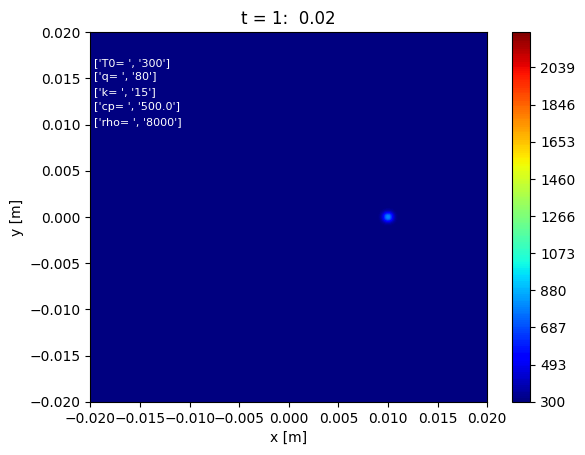

In [81]:
fig = plt.figure()

plt.rcParams.update({'text.color': "Black"})
ax = plt.axes(xlim=((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale)), ylim=((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale)),xlabel='x [m]',ylabel='y [m]')
plt.rcParams.update({'text.color': "white"})
#ax.text(0.01, 0.95,['v(x,y)= ', (str(vx),str(vy))], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.91,['T0= ', str(T0)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.87,['q= ', str(q)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.83,['k= ', str(k)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.79,['cp= ', str(cp)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.75,['rho= ', str(rho)], transform=ax.transAxes,fontsize=8);
plt.rcParams.update({'text.color': "Black"})

cvals = np.linspace(T0,T_Max*(Temp_sensitivity/100),Temp_Definition)     # set contour values
cont = plt.contourf(x, y, T0_Mat, cvals,cmap = cm.jet)    # first image on screen
plt.colorbar(cont)

n = int(Data_points/Frames_Used);
def Trial_Data(Frm):   # function returns a 2D data array
  global n
  return Trial_Temps[((n*Frm)*ny):((n*Frm)+1)*ny][:]

# animation function
def animate(dp):
    global cont
    T_Array = Trial_Data(dp)
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(x, y, T_Array, cvals,cmap = cm.jet)
    plt.title('t = %i:  %.2f' % (dp+1,Time[int((n*dp)+1)]))
    return cont

anim = animation.FuncAnimation(fig, animate, frames=Frames_Used, repeat=False)
from IPython.display import HTML
HTML(anim.to_html5_video())